In [76]:
import import_ipynb
from bstar_deblaze import bstar_deblazed2
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal as sc
import os
import datetime
# Read in data from wavelength solution
wave_soln = (pf.open('apf_wav.fits'))[0].data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


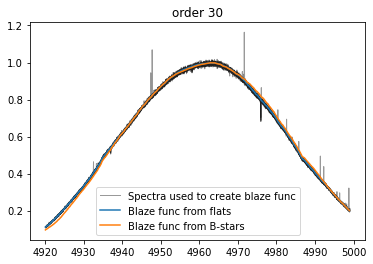

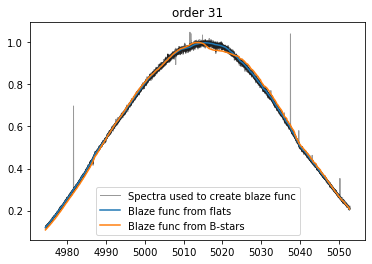

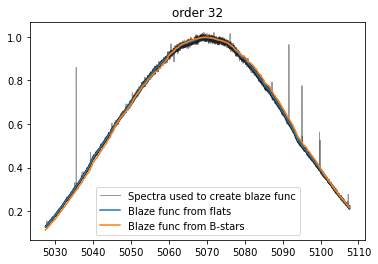

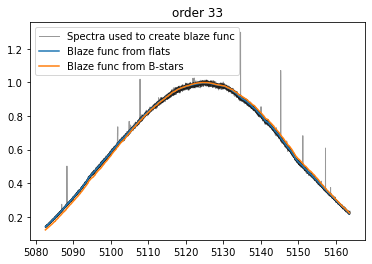

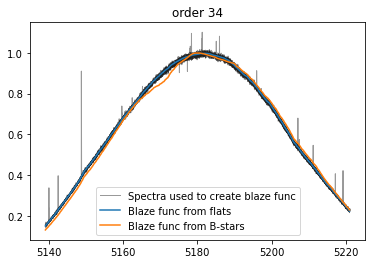

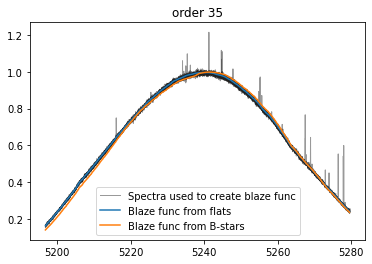

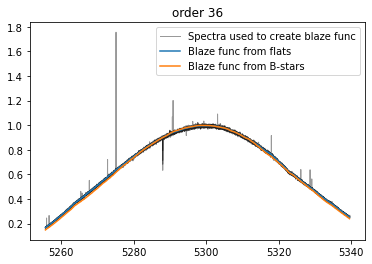

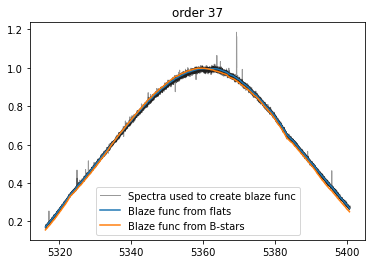

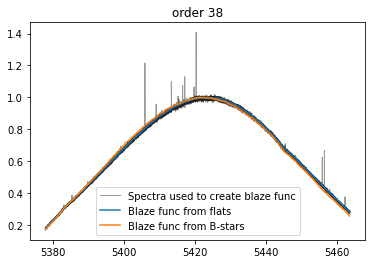

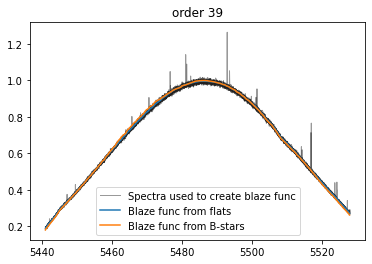

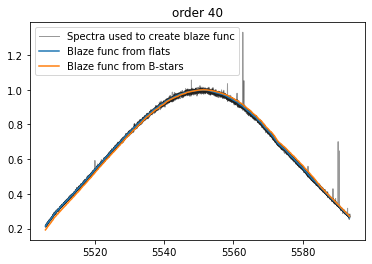

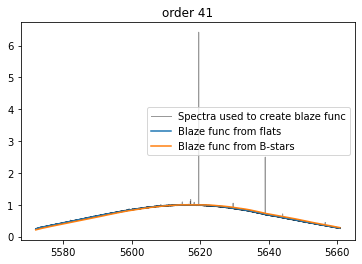

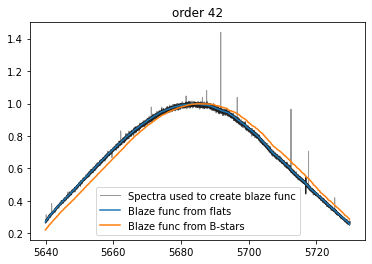

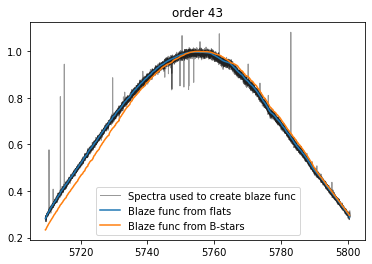

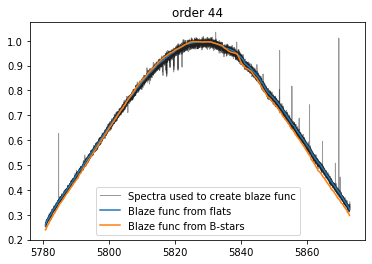

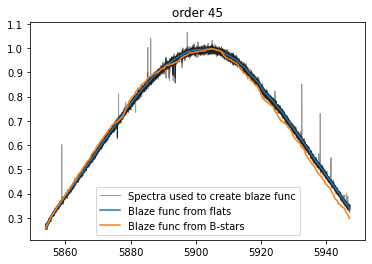

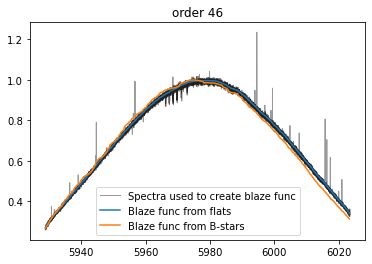

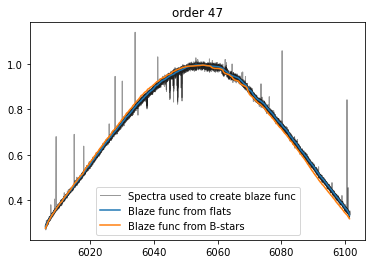

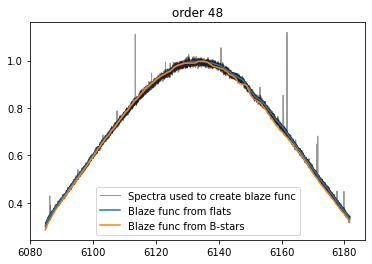

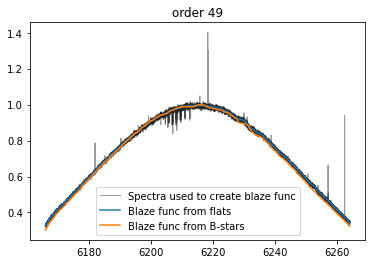

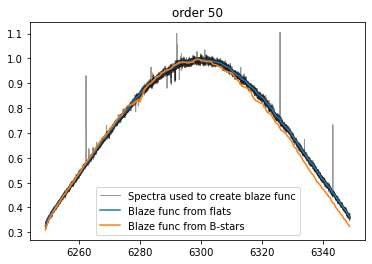

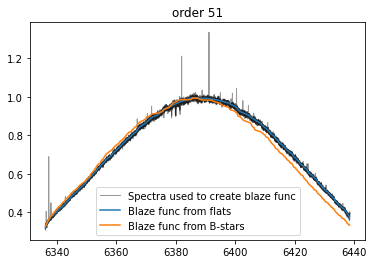

In [85]:
# make new blaze functions

blaze_type = 'flats' # or 'flats'

# Use flats instead of b-stars:
if blaze_type == 'flats':
    dir_path = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/flats'
if blaze_type == 'bstars':
    dir_path = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/bstars'

filenames = os.listdir(dir_path)

individual_spectra = []
data = np.zeros((79, 4608))
for filename in filenames:
    file = pf.open(dir_path + '/' + filename)
    data_part = file[0].data
    data += data_part
    individual_spectra += [data_part]

def median_fit_deblazed(data, order, make_funcs): 
                                                        
    wave = pf.open('apf_wav copy.fits')
    wave_values = wave[0].data
    
    x = wave_values[order,0:4600] 
    y = data[order,0:4600]
    
    # normalize y values to 1
    y_norm = y/np.percentile(np.sort(y),99)
    
    # IF RUNNING SCRIPT TO PRODUCE BLAZE FUNCTION 
    if make_funcs:
        y_medfit = sc.medfilt(y_norm, kernel_size = 151)
        all_blaze = y_medfit
        return all_blaze # return blaze func for this order, exit the function

if blaze_type == 'flats':
    flat_blaze_func = np.zeros((22, 4600))
if blaze_type == 'bstars':
    bstar_blaze_func = np.zeros((22, 4600))
for order_inc in range(22):   
        if blaze_type == 'flats':
            flat_blaze_func[order_inc, :4600] = median_fit_deblazed(data, 30 + order_inc, make_funcs=True)
        if blaze_type == 'bstars':
            bstar_blaze_func[order_inc, :4600] = median_fit_deblazed(data, 30 + order_inc, make_funcs=True)
        # the last 8 pixels are zero
        #flat_blaze_func[order_inc, -8:] = np.ones(8) * flat_blaze_func[ order_inc, -9]     
        #flat_blaze_func[order_inc] = flat_blaze_func[order_inc, 0:-8]
        plt.figure()
        for i in range(len(individual_spectra)):
            spect = individual_spectra[i]
            if i == 0:
                plt.plot(wave_soln[30 + order_inc], spect[30 + order_inc][:-1]/np.percentile(spect[30 + order_inc],99), color = 'k', alpha = 0.4, lw = 1, label = 'Spectra used to create blaze func')  
            else:
                plt.plot(wave_soln[30 + order_inc], spect[30 + order_inc][:-1]/np.percentile(spect[30 + order_inc],99), color = 'k', alpha = 0.4, lw = 1)#, label = 'Flats')  
        #plt.plot(flat_data[30 + order_inc]/np.percentile(flat_data[30 + order_inc],99), color = 'k', alpha = 0.4, lw = 3, label = 'Combined flats')
        plt.plot(wave_soln[30 + order_inc][:-7], flat_blaze_func[order_inc], label = 'Blaze func from flats')
        plt.plot(wave_soln[30 + order_inc][:-7], bstar_blaze_func[order_inc], label = 'Blaze func from B-stars')
        plt.title('order ' + str(30 + order_inc))
        plt.legend()
        
        



In [68]:
# save the blaze functions

if os.path.exists('/mnt_home/azuckerman/BL_APF_DAP/flats_blaze_funcs.csv'):
    dt = datetime.datetime.now()
    timestamp = dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '-' + dt.strftime("%X") 
    os.rename('/mnt_home/azuckerman/BL_APF_DAP/flats_blaze_funcs.csv', '/mnt_home/azuckerman/BL_APF_DAP/flats_blaze_funcs_' + timestamp + '.csv')

#np.savetxt("flats_blaze_funcs.csv", np.vstack([np.arange(flat_blaze_func, delimiter = ",")
to_save = pd.DataFrame(flat_blaze_func, index = np.arange(30,52,1).tolist())
to_save.to_csv('flats_blaze_funcs.csv')

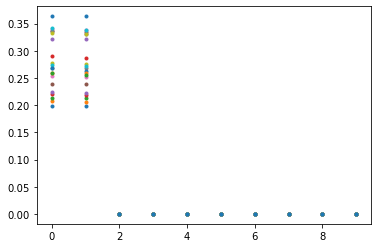

In [48]:
# the last 8 pixels were zero --> this is why we only go up tp 4600
for order in np.arange(30,51,1):
    
    plt.plot(flat_blaze_func[order,-10:], '.')